<h3>HW 4</h3>

**Problem 1**

In [324]:
import sys
import math
import copy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import base
from sklearn.metrics import classification_report, confusion_matrix
from pprint import pprint
import pandas as pd
from sklearn.model_selection import cross_val_score

In [325]:
#function to calculate entropy of one class which have ci objects of class i out of n elements
def entropy_func(ci, n):
    return -(ci*1.0/n)*math.log(ci*1.0/n, 2)

#function to calculate entropy of 2 classes using the above function
def entropy_cal(c1, c2):
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

# entropy of all the classes in one bucket
def entropy_of_one_division(division): 
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

# entropy of both the childs
def total_entropy(y_predict, y_real):
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

In [326]:
class DecisionTreeClasifier(object):
    def __init__(self,feature_names,max_depth):
        self.feature_names=feature_names
        self.depth = 0
        self.max_depth = max_depth
    
    def fit(self, x, y, par_node={}, depth=0):
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy,info_gain = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': self.feature_names[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y)),
                       'entropy':entropy,
                       'info_gain':info_gain}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    def find_best_split_of_all(self, x, y):
        col = None
        min_entropy = 1
        min_info_gain=10
        cutoff = None
        for i, c in enumerate(x.T):
            #entropy, cur_cutoff = self.find_best_split(c, y)
            entropy,info_gain,cur_cutoff=self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy,info_gain
            elif entropy <= min_entropy:
                min_entropy = entropy
                min_info_gain=info_gain
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy,min_info_gain
    
    def find_best_split(self, col, y):
        min_entropy = 10
        n = len(y)
        entropy_parent=entropy_of_one_division(y)[0]
        for value in set(col):
            y_predict = col < value
            my_entropy = total_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
                min_info_gain=entropy_parent-my_entropy
        return min_entropy, min_info_gain, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

In [327]:
import pandas as pd

data = pd.read_csv("data.csv")#get_data()
data.head()

,Age,Salary,College Degree
0,24,40000,Yes
1,53,52000,No
2,23,25000,No
3,25,77000,Yes
4,32,48000,Yes


In [328]:
def degree_to_id(value):
    if value == 'Yes':
        return 1
    return 0
data.iloc[:,-1]=data.iloc[:,-1].map(degree_to_id)

In [471]:
x=np.array(data.iloc[:,0:2])
x
y=np.array(data.iloc[:,-1])
y

array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1], dtype=int64)

Now, lets fit the model built and see the **Information Gain, Entropy at each of the split**

In [330]:
clf = DecisionTreeClasifier(data.columns,max_depth=7)
m = clf.fit(x, y)
pprint(m)

{'col': 'Salary',
 'cutoff': 38000,
 'entropy': 0.6490224995673063,
 'index_col': 1,
 'info_gain': 0.3219280948873623,
 'left': {'val': 0},
 'right': {'col': 'Age',
           'cutoff': 43,
           'entropy': 0.5,
           'index_col': 0,
           'info_gain': 0.31127812445913283,
           'left': {'val': 1},
           'right': {'col': 'Salary',
                     'cutoff': 65000,
                     'entropy': 0.0,
                     'index_col': 1,
                     'info_gain': 1.0,
                     'left': {'val': 0},
                     'right': {'val': 1},
                     'val': 0.0},
           'val': 1.0},
 'val': 1.0}


**1.2**

Thank you Abhisek Panigrahi (abpani) for discussing the idea of Perceptron way of building the multi-variate decision tree. Using his approach for the below implementation.

In [539]:
data2=data.copy()
data2['pred']=-100
gains=[]
np.random.seed(43)
a= np.random.rand()
b=np.random.rand()
parent_entropy=entropy_of_one_division(y)[0]
parent_count=y.shape[0]
gain=0
for _ in range(100):
    for i in data2.index:
        x1=data2.iloc[i].values[0]
        x2=data2.iloc[i].values[1]
        #print(i,xage,xsalary)
        if a*x1+b*x2-1<0:
            data2.loc[i,'pred']=0
            if(data2.loc[i,'pred']!=data2.loc[i,'College Degree']):
                a=a+x1
                b=b+x2
        else:
            data2.loc[i,'pred']=1
            if(data2.loc[i,'pred']!=data2.loc[i,'College Degree']):
                a=a-x1
                b=b-x2
    
    left=data2.loc[data2['pred']==0,'College Degree']
    left_count=left.shape[0]
    right=data2.loc[data2['pred']==1,'College Degree']
    right_count=right.shape[0]
    left_ent=entropy_of_one_division(left)[0]
    right_ent=entropy_of_one_division(right)[0]
    avg=(left_ent*(left_count/parent_count)+right_ent*(right_count/parent_count))
    gain=parent_entropy-avg
    print("alpha={}, beta={}, gain={}".format(a,b,gain))
    if(gain==parent_entropy):
        break

alpha=-22.884945433610227, beta=46000.60906653928, gain=0.01997309402197489
alpha=-145.88494543361023, beta=0.6090665392694063, gain=0.007403392114696539
alpha=-168.88494543361023, beta=46000.60906653927, gain=0.01997309402197489
alpha=-291.88494543361026, beta=0.6090665392694063, gain=0.007403392114696539
alpha=-314.88494543361026, beta=46000.60906653927, gain=0.01997309402197489
alpha=-437.88494543361026, beta=0.6090665392694063, gain=0.007403392114696539
alpha=-460.88494543361026, beta=46000.60906653927, gain=0.01997309402197489
alpha=-583.8849454336103, beta=0.6090665392694063, gain=0.007403392114696539
alpha=-606.8849454336103, beta=46000.60906653927, gain=0.01997309402197489
alpha=-729.8849454336103, beta=0.6090665392694063, gain=0.007403392114696539
alpha=-729.8849454336103, beta=0.6090665392694063, gain=0.9709505944546686


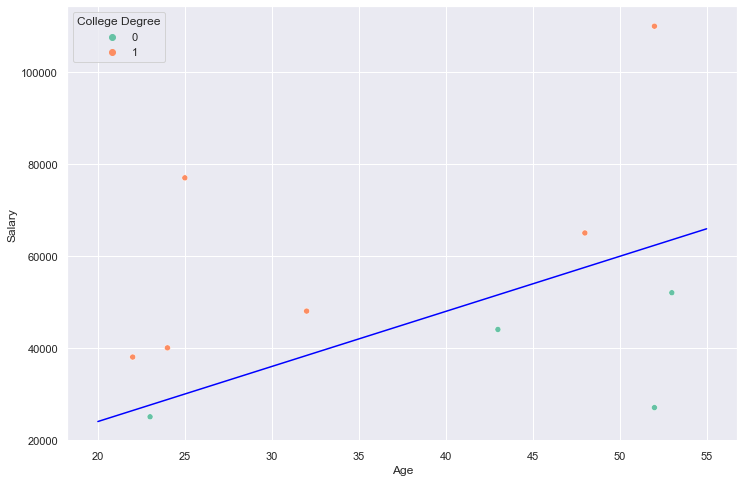

In [525]:
fig2 = plt.figure()
fig2.set_size_inches(12,8)
ax2 = plt.axes()
ax2=sns.scatterplot(data=data,x='Age',y='Salary',hue='College Degree',palette='Set2')
xx=np.linspace(20,55,2)
ax2.plot(xx,(-1*(1/b)-(a/b)*xx),color='blue')

There is another algorithm which is mentioned in the below paper by Olcay Taner Yıldız, Ethem Alpaydın which explains how to update the coefficients for each cycle. 
https://web.njit.edu/~usman/courses/cs675_fall16/Comparing_Univariate_and_Multivariate_De.pdf

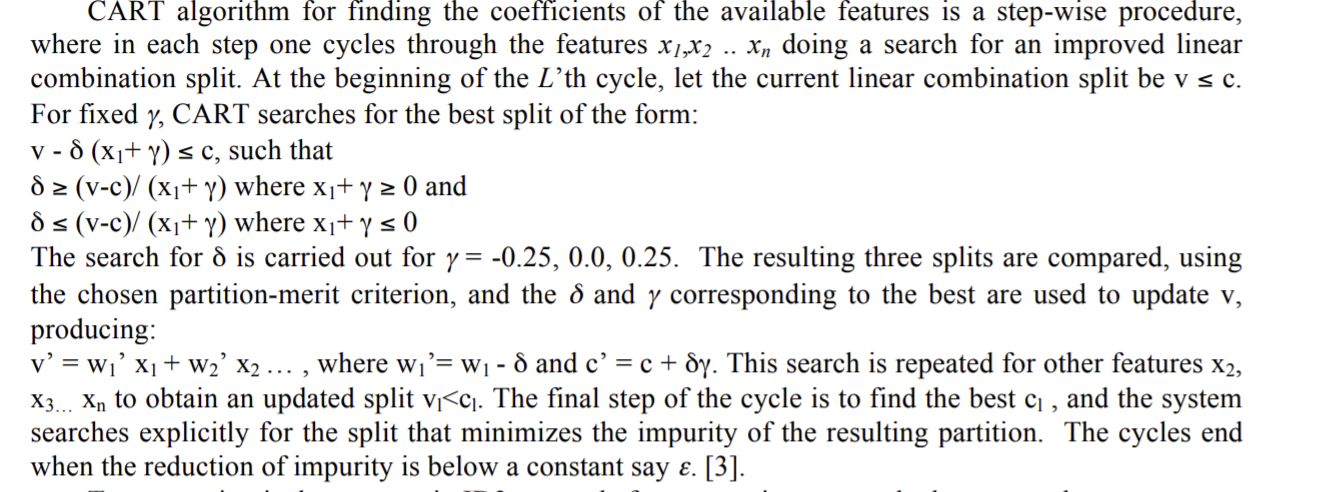

**1.3**

**Advantages:**

Univariate by definition means involving one variate or variable quantity. On the other hand, multivariate means using multiple or more than one variate or variable quantity at the same time. Therefore, multivariate decision trees can use use all attributes at one node when branching. For the linearly separable datasets, multivariate decision trees converge much faster than univarate decision trees.

**Disadvantages:**

Hyperplanes with an arbitrary orientation are usedin multivariate trees. It means that there can be

$2^d$ ${N \choose d}$ possible Hyperplanes.

(where d is the number of dimensions and N is the number of possible thresholds for the split points)

which makes exhaustive search inefficient and impractical. Consequently, a more practical way to follow is using linear multivariate node that takes weights for each attribute and sums them up . Moreover, linear multivariate decision trees choose the most important attributes amongst all so that the process would become more efficient and practical.

Also, the univariate decision trees are used mainly for the interpretibility of the feature importance which won't be possible for multivariate trees.

<h3>Question 2<h3>

<h3>Bagging:</h3>
Bagging is used when the goal is to reduce the variance of a decision tree classifier. Here the objective is to create several subsets of data from training sample chosen randomly with replacement. Each collection of subset data is used to train their decision trees. As a result, we get an ensemble of different models. Average of all the predictions from different trees are used which is more robust than a single decision tree classifier.

**When can Bagging be effective ?**

An *Unstable Learner* means small change in data, can give incorrect results of the same model. Decision Trees are unstable learners. So bagging because of their inherent property of reducing model variance, makes unstable learner more resilient to the data changes.

**Advantages:**

<li>Reduces over-fitting of the model.
<li>Handles higher dimensionality data very well.
<li>Maintains accuracy for missing data.
<li>Makes unstable learner stable

**Disadvantages:**

<li>Since final prediction is based on the mean predictions from subset trees, it won’t give precise values for the classification and regression model.
<li>Bagging improves prediction,accuracy at the expense of interpretability.

<h3>Boosting:</h3>
Boosting is used to create a collection of predictors. In this technique, learners are learned sequentially with early learners fitting simple models to the data and then analysing data for errors. Consecutive trees (random sample) are fit and at every step, the goal is to improve the accuracy from the prior tree. When an input is misclassified by a hypothesis, its weight is increased so that next hypothesis is more likely to classify it correctly. This process converts weak learners into better performing model.

**Advantages:**

Supports different loss function.<br>
Works well with interactions.<br>
It is very fast<br>
Any weak learner can work with the algorithm.<br>
Can be used with all data types. <br>
It is versatile.<br>

**Disadvantages:**

Prone to over-fitting.<br>
Requires careful tuning of different hyper-parameters.<br>
Susceptible to uniform noise<br>

In [3]:
class Bagging:
    
    def fit(self, X_train, y_train, B, max_depth = 100, seed = None):
        
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.y_train = y_train
        self.B = B
        self.seed = seed
        self.trees = []
        
        np.random.seed(seed)
        for b in range(self.B):
            
            sample = np.random.choice(np.arange(self.N), size = self.N, replace = True)
            X_train_b = X_train[sample]
            y_train_b = y_train[sample]
            
            tree = DecisionTreeClassifier(max_depth = max_depth)
            tree.fit(X_train_b, y_train_b)
            self.trees.append(tree)
            
        
    def predict(self, X_test):
        
        y_test_hats = np.empty((len(self.trees), len(X_test)))
        y_pred=np.empty(len(X_test))
        for i, tree in enumerate(self.trees):
            y_test_hats[i] = tree.predict(X_test)
        
        for i in range(len(X_test)):
            y_pred[i]=np.bincount(y_test_hats[:,i].astype(int)).argmax()
        
        return y_pred#np.where(y_test_hat.sum(0)>0,1,-1)
    
    def plot_errors(self, X_train,y_train,X_test,y_test):
        
        y_test_hats = np.empty((len(self.trees), len(X_test)))
        y_train_hats = np.empty((len(self.trees), len(X_train)))
        errors_train=np.empty(len(self.trees))
        errors_test=np.empty(len(self.trees))
        for i, tree in enumerate(self.trees):
            y_test_hats[i] = tree.predict(X_test)
            y_train_hats[i]=tree.predict(X_train)
            errors_train[i]=1-(len(y_train[y_train_hats[i]==y_train])/len(y_train))
            errors_test[i]=1-(len(y_test[y_test_hats[i]==y_test])/len(y_test))
        plt.figure(figsize=(15,6))
        sns.set_theme(style="darkgrid")
        plt.plot(errors_train,c='b')
        plt.plot(errors_test,c='r')
        plt.legend(['Train Error','Test Error'],loc='center right',bbox_to_anchor=(1.3,0.5))

**Adaboost**

In [23]:
# Compute error rate, alpha and w
def compute_error(y, y_pred, w_t):
    return (sum(w_t * (np.not_equal(y, y_pred)).astype(int)))/sum(w_t)

def compute_beta(error):
    return np.log((1 - error) / error)

def update_weights(w_t, beta, y, y_pred):
    return w_t * np.exp(beta * (np.not_equal(y, y_pred)).astype(int))

# Define AdaBoost class
class AdaBoost:
    
    def __init__(self,T=100,max_depth=1):
        self.betas = []
        self.trees = []
        self.T = T
        self.training_errors = []
        self.prediction_errors = []
        self.max_depth=max_depth
        
    def fit(self, X, y):        
        # Clear before calling
        self.betas = [] 
        self.training_errors = []
        # Iterate over T weak classifiers
        for t in range(0, self.T):
            # Set weights for current boosting iteration
            if t == 0:
                w_t = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_t
                w_t = update_weights(w_t, beta_t, y, y_pred)
            # (a) Fit weak classifier and predict labels
            tree_t = DecisionTreeClassifier(max_depth = self.max_depth)     # Stump: Two terminal-node classification tree
            tree_t.fit(X, y, sample_weight = w_t)
            y_pred = tree_t.predict(X)
            self.trees.append(tree_t) # Save to list of weak classifiers

            # (b) Compute error
            error_t = compute_error(y, y_pred, w_t)
            self.training_errors.append(error_t)

            # (c) Compute beta
            beta_t = compute_beta(error_t)
            self.betas.append(beta_t)

        assert len(self.trees) == len(self.betas)
        
    def predict(self, X):
        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.T)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for t in range(self.T):
            y_pred_t = self.trees[t].predict(X) * self.betas[t]
            weak_preds.iloc[:,t] = y_pred_t
            
        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred
    
    def test_errors(self,X_test,y_test):
        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X_test)), columns = range(self.T)) 
        # Predict class label for each weak classifier, weighted by alpha_m
        for t in range(self.T):
            y_pred_t = self.trees[t].predict(X_test)
            self.prediction_errors.append(1-(len(y_test[np.sign(y_pred_t)==y_test])/len(y_test)))
        return self.prediction_errors

**Letter Dataset**

In [135]:
# Dataset
df = pd.read_csv('letter-recognition.data', header = None)
df=df[(df.iloc[:,0]=='C') | (df.iloc[:,0]=='G')]

In [136]:
df[0]=df[0].astype('category').cat.codes

In [137]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:17].values, 
                                                    df.iloc[:,0].values, 
                                                    random_state = 2)
y_train=np.where(y_train==0,-1,1)
y_test=np.where(y_test==0,-1,1)

**Boosting on Letter Dataset**

In [117]:
# Fit model
ab = AdaBoost(T=100,max_depth=2)
ab.fit(X_train,y_train)

# Predict on test set
y_pred = ab.predict(X_test)

In [11]:
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 98.94%


In [25]:
test_errors=ab.test_errors(X_test,y_test)

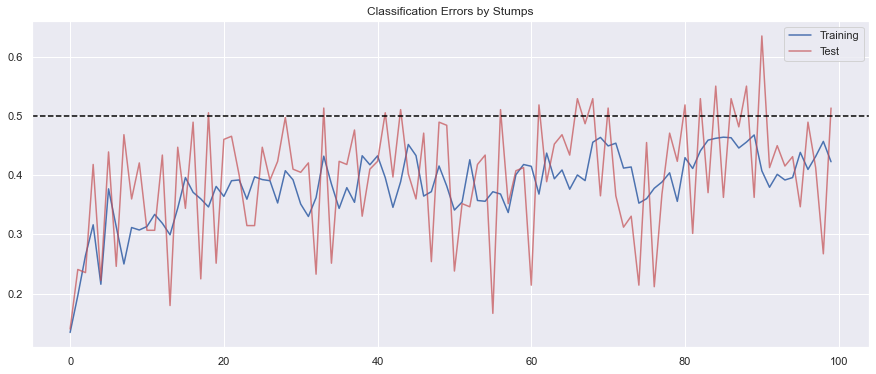

In [35]:
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
plt.plot(ab.training_errors)
plt.plot(ab.prediction_errors,c='r',alpha=0.7)
plt.axhline(0.5,c='black',linestyle='--')
plt.legend(['Training','Test'])
plt.title('Classification Errors by Stumps')
plt.show()

We can clearly see that, some of the stumps (weak classifier) are worse than 0.5 which means worse than random choice. But the final accuracy is ~99%. Now let's see the power of boosting with further analysis. I will vary the hyper parameters (T, depth)to see if efficiency increases.

In [63]:
depths = [1,2,5]
n_estimators = [1,2,3,4,5,6,7,8,9,10,50,100,200,300,400,500,1000,2000]
letter_train_errorrates=np.empty((len(depths),len(n_estimators)))
letter_test_errorrates=np.empty((len(depths),len(n_estimators)))
for i in range(len(depths)):
    depth=depths[i]
    for j in range(len(n_estimators)):
        estimators=n_estimators[j]
        #print(depth,estimators),
        ab = AdaBoost(T=estimators,max_depth=depth)
        ab.fit(X_train, y_train)
        y_pred = ab.predict(X_test)
        y_train_pred=ab.predict(X_train)
        train_accuracy= len(y_train[y_train_pred==y_train])/len(y_train)
        test_accuracy = len(y_test[y_pred==y_test])/len(y_test)
        letter_train_errorrates[i][j]=1-train_accuracy
        letter_test_errorrates[i][j]=1-test_accuracy

In [64]:
tex=['Train Depth-']*len(depths)
tex+=(['Test Depth-']*len(depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, depths*2)]

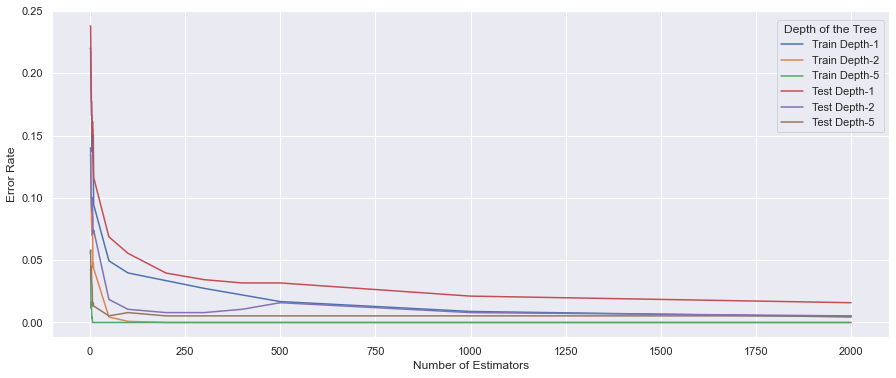

In [65]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":n_estimators, "acc":letter_train_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":n_estimators, "acc":letter_test_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg,loc='center right',bbox_to_anchor=(1,0.8),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

We can see that, for depth=5, test error is lower than others and it converged in very few iterations. Now let's check if the model is overfitting by doing cross-validation for different depths.

In [159]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

cv_scores=np.zeros(20)
test_scores=np.zeros(20)
for i in range(1,21):
    ad2=AdaBoostClassifier(n_estimators=100,base_estimator=DecisionTreeClassifier(max_depth=i))
    ad2.fit(X_train,y_train)
    y_pred = ad2.predict(X_test)
    cv_scores[i-1] =np.mean(cross_val_score(ad2, X_train,y_train, cv=5))
    test_scores[i-1]=len(y_test[y_pred==y_test])/len(y_test)
    

Text(0.5, 0, 'Depth of the Tree')

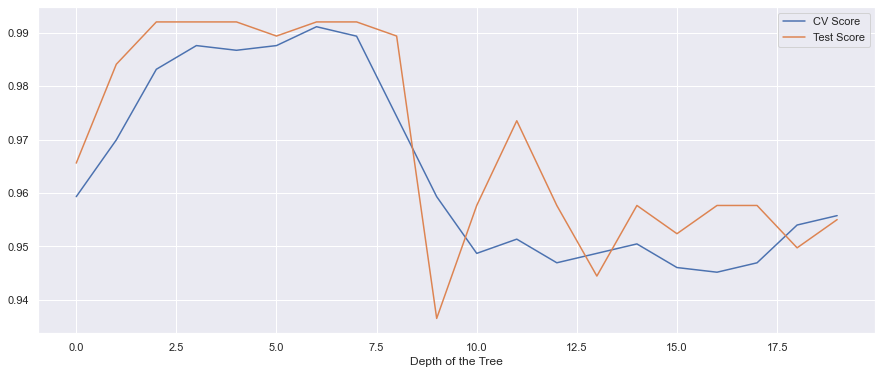

In [160]:
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
plt.plot(cv_scores)
plt.plot(test_scores)
plt.legend(['CV Score','Test Score'])
plt.xlabel('Depth of the Tree')

We can see that overall test error is decreasing as the depth of increasing, this can be due to overfitting. The optimal depth is <=2 in terms of computational efficiency.

**Bagging on Letter Dataset**

In [169]:
## Build model
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:17].values, 
                                                    df.iloc[:,0].values, 
                                                    random_state = 2)
bagging = Bagging()
bagging.fit(X_train, y_train, B = 1000, max_depth = 2, seed = 123)
y_pred = bagging.predict(X_test)

In [94]:
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 85.98%


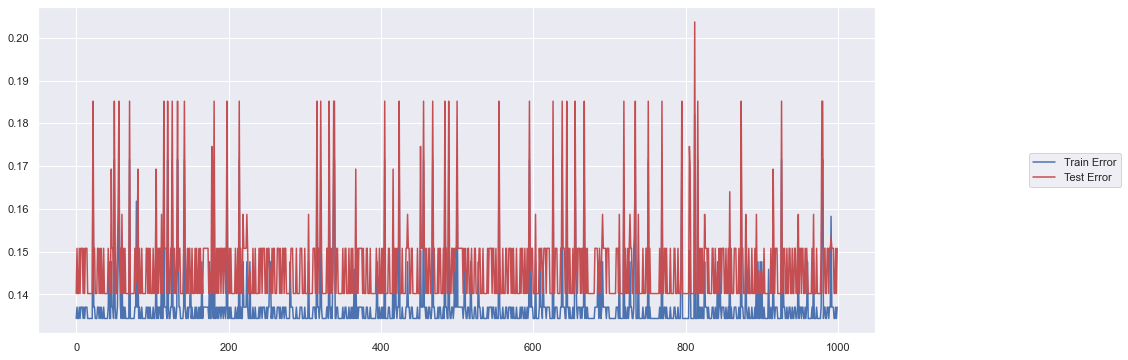

In [95]:
bagging.plot_errors(X_train,y_train,X_test,y_test)

In [72]:
depths = [1,2,5,50]
numbags = range(1,100,4)
letter_train_bag_errorrates=np.empty((len(depths),len(numbags)))
letter_test_bag_errorrates=np.empty((len(depths),len(numbags)))
for i in range(len(depths)):
    depth=depths[i]
    for j in range(len(numbags)):
        bags=numbags[j]
        bagging = Bagging()
        bagging.fit(X_train, y_train, B = bags, max_depth = depth, seed = 123)
        train_y_pred=bagging.predict(X_train)
        test_y_pred = bagging.predict(X_test)
        train_accuracy = len(y_train[train_y_pred==y_train])/len(y_train)
        test_accuracy = len(y_test[test_y_pred==y_test])/len(y_test)
        letter_train_bag_errorrates[i][j]=1-train_accuracy
        letter_test_bag_errorrates[i][j]=1-test_accuracy
        

In [74]:
tex=['Train Depth-']*len(depths)
tex+=(['Test Depth-']*len(depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, depths*2)]

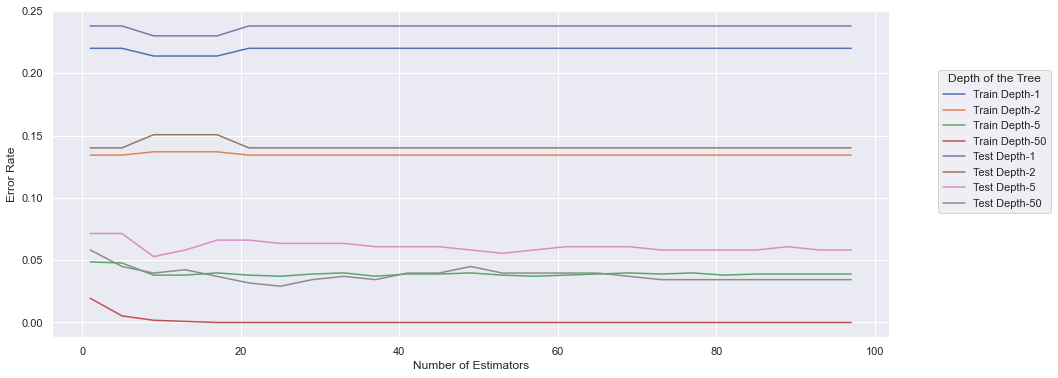

In [80]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":numbags, "acc":letter_train_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":numbags, "acc":letter_test_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg,loc='center right',bbox_to_anchor=(1.2,0.6),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

The idea of Bagging is to reduce variance of the data. Let's see if that is happening or not, by doing cross validation on the base learner model.

In [163]:
dc=DecisionTreeClassifier(max_depth=50)
dc.fit(X_train,y_train)
scores=cross_val_score(dc,X_train,y_train,cv=5)
y_pred=dc.predict(X_test)

In [165]:
np.mean(scores)

0.9540173872363651

In [164]:
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 96.03%


Now, let's compare with Bagging output.

In [172]:
bagging = Bagging()
bagging.fit(X_train, y_train, B = 2000, max_depth = 50, seed = 123)
y_pred = bagging.predict(X_test)
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 96.56%


There is an improvement of accuracy by 0.5% compared to the base learner.

Let's plot Bagging vs Boosting test errors as a function of T (bags for bagging, n_estimators for boosting). I would expect boosting to outperform bagging as seen above. But, still we need to remember, Boosting is prone to overfitting.

In [186]:
bagging_depths=[1,50]
boost_depths = [1,2]
n = [1,2,3,4,5,6,7,8,9,10,50,100,200,300,400,500,1000,2000]
test_boost_errorrates=np.empty((len(depths),len(n)))
test_bag_errorrates=np.empty((len(depths),len(n)))
for i in range(len(bagging_depths)):
    bag_depth=bagging_depths[i]
    boost_depth=boost_depths[i]
    
    for j in range(len(n)):
        rep=n[j]
        bagging = Bagging()
        bagging.fit(X_train, y_train, B = rep, max_depth = bag_depth, seed = 123)
        test_y_pred = bagging.predict(X_test)
        test_accuracy = len(y_test[test_y_pred==y_test])/len(y_test)
        test_bag_errorrates[i][j]=1-test_accuracy
        
        y_train2=np.where(y_train==0,-1,1)
        y_test2=np.where(y_test==0,-1,1)    
        ab = AdaBoost(T=rep,max_depth=boost_depth)
        ab.fit(X_train, y_train2)
        test_y_pred = ab.predict(X_test)
        test_accuracy = len(y_test2[test_y_pred==y_test2])/len(y_test2)
        test_boost_errorrates[i][j]=1-test_accuracy

In [187]:
test_bag_errorrates

array([[0.23809524, 0.23015873, 0.23809524, 0.23809524, 0.23809524,
        0.23809524, 0.23809524, 0.23015873, 0.23015873, 0.23015873,
        0.23809524, 0.23809524, 0.23809524, 0.23809524, 0.23809524,
        0.23809524, 0.23809524, 0.23809524],
       [0.05820106, 0.04761905, 0.04232804, 0.04761905, 0.04497354,
        0.03968254, 0.04232804, 0.03439153, 0.03968254, 0.03703704,
        0.04232804, 0.03439153, 0.03703704, 0.03703704, 0.03703704,
        0.03703704, 0.03439153, 0.03439153]])

In [188]:
test_boost_errorrates

array([[0.23809524, 0.23809524, 0.2037037 , 0.17724868, 0.17724868,
        0.15079365, 0.16137566, 0.15079365, 0.15079365, 0.11640212,
        0.06878307, 0.05555556, 0.03968254, 0.03439153, 0.03174603,
        0.03174603, 0.02116402, 0.01587302],
       [0.14021164, 0.14021164, 0.10846561, 0.0952381 , 0.08994709,
        0.0978836 , 0.1005291 , 0.07142857, 0.07142857, 0.07407407,
        0.01851852, 0.01058201, 0.00793651, 0.00793651, 0.01058201,
        0.01587302, 0.00793651, 0.00529101]])

In [189]:
tex=['Bagging Depth-']*len(bagging_depths)
tex1=(['Boosting Depth-']*len(boost_depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, bagging_depths)]
leg1=["{}{}".format(a_, b_) for a_, b_ in zip(tex1, boost_depths)]
leg_final=leg+leg1

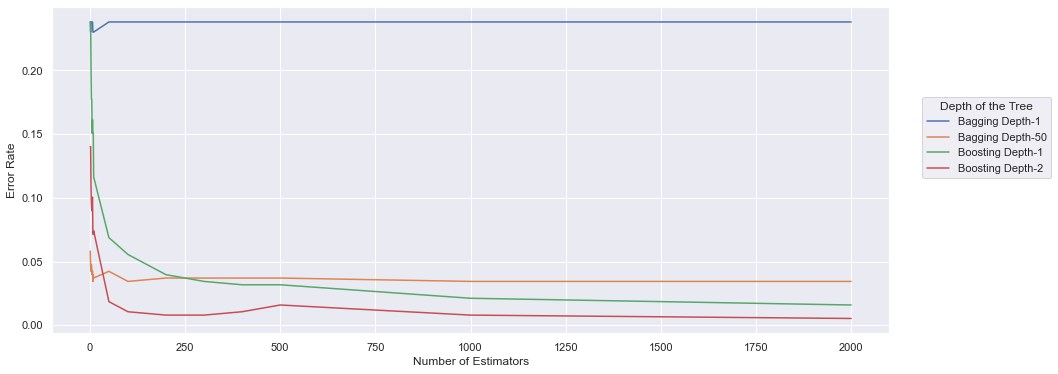

In [190]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(bagging_depths)):
    data_plot = pd.DataFrame({"n_estimators":n, "acc":test_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(bagging_depths)):
    data_plot = pd.DataFrame({"n_estimators":n, "acc":test_boost_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg_final,loc='center right',bbox_to_anchor=(1.2,0.6),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

In [238]:
letter_bag_errors=test_bag_errorrates
letter_boost_errors=test_boost_errorrates

So, it can be seen that Boosting Depth-2 is out-performing by a margin for Letter Dataset.

**Spam Dataset**

In [191]:
# Dataset
df = pd.read_csv('spambase.data', header = None)

# Column names
names = pd.read_csv('spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')

# Rename df columns
df.columns = col_names

# Convert classes in target variable to {-1, 1}
df['Spam'] = df['Spam'] * 2 - 1

# Train - test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'Spam').values, 
                                                    df['Spam'].values, 
                                                    train_size = 3065, 
                                                    random_state = 2) 

**Boosting on Spam Dataset**

In [194]:
# Fit model
ab = AdaBoost(T=100,max_depth=2)
ab.fit(X_train,y_train)

# Predict on test set
y_pred = ab.predict(X_test)

In [195]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[879  29]
 [ 48 580]]
              precision    recall  f1-score   support

          -1       0.95      0.97      0.96       908
           1       0.95      0.92      0.94       628

    accuracy                           0.95      1536
   macro avg       0.95      0.95      0.95      1536
weighted avg       0.95      0.95      0.95      1536



In [196]:
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 94.99%


In [197]:
test_errors=ab.test_errors(X_test,y_test)

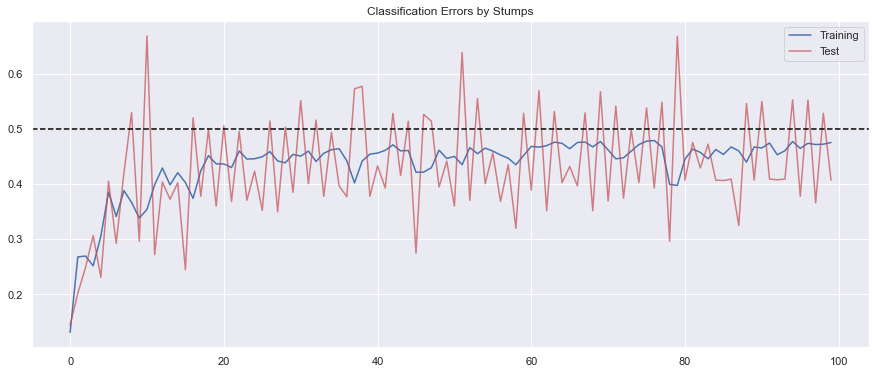

In [198]:
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
plt.plot(ab.training_errors)
plt.plot(ab.prediction_errors,c='r',alpha=0.7)
plt.axhline(0.5,c='black',linestyle='--')
plt.legend(['Training','Test'])
plt.title('Classification Errors by Stumps')
plt.show()

In [200]:
depths = [1,2,5]
n_estimators = [1,2,3,4,5,6,7,8,9,10,50,100,200,300,400,500,1000,2000]
spam_train_errorrates=np.empty((len(depths),len(n_estimators)))
spam_test_errorrates=np.empty((len(depths),len(n_estimators)))
for i in range(len(depths)):
    depth=depths[i]
    for j in range(len(n_estimators)):
        estimators=n_estimators[j]
        #print(depth,estimators),
        ab = AdaBoostClassifier(n_estimators=estimators,base_estimator=DecisionTreeClassifier(max_depth=depth))
        ab.fit(X_train, y_train)
        y_pred = ab.predict(X_test)
        y_train_pred=ab.predict(X_train)
        train_accuracy= len(y_train[y_train_pred==y_train])/len(y_train)
        test_accuracy = len(y_test[y_pred==y_test])/len(y_test)
        spam_train_errorrates[i][j]=1-train_accuracy
        spam_test_errorrates[i][j]=1-test_accuracy

In [201]:
tex=['Train Depth-']*len(depths)
tex+=(['Test Depth-']*len(depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, depths*2)]

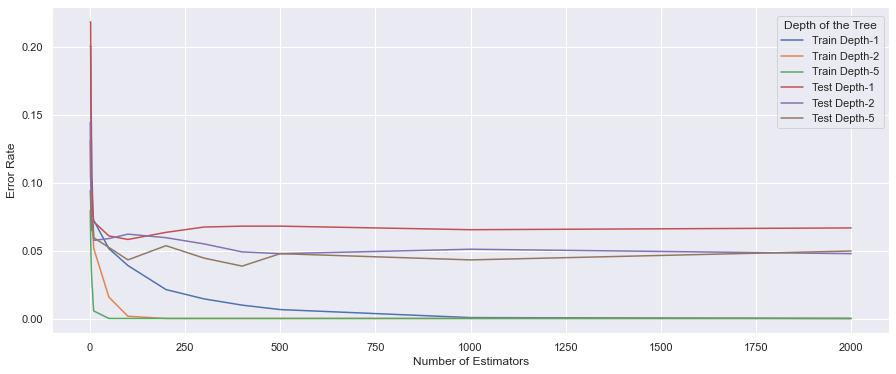

In [202]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":n_estimators, "acc":spam_train_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":n_estimators, "acc":spam_test_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg,loc='center right',bbox_to_anchor=(1,0.8),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

We can see that, for depth=2,5, test error is lower and almost equal and it converged in very few iterations. Now let's check if the model is overfitting by doing cross-validation for different depths.

In [204]:
cv_scores=np.zeros(20)
test_scores=np.zeros(20)
for i in range(1,21):
    ad2=AdaBoostClassifier(n_estimators=100,base_estimator=DecisionTreeClassifier(max_depth=i))
    ad2.fit(X_train,y_train)
    y_pred = ad2.predict(X_test)
    cv_scores[i-1] =np.mean(cross_val_score(ad2, X_train,y_train, cv=5))
    test_scores[i-1]=len(y_test[y_pred==y_test])/len(y_test)  

Text(0.5, 0, 'Depth of the Tree')

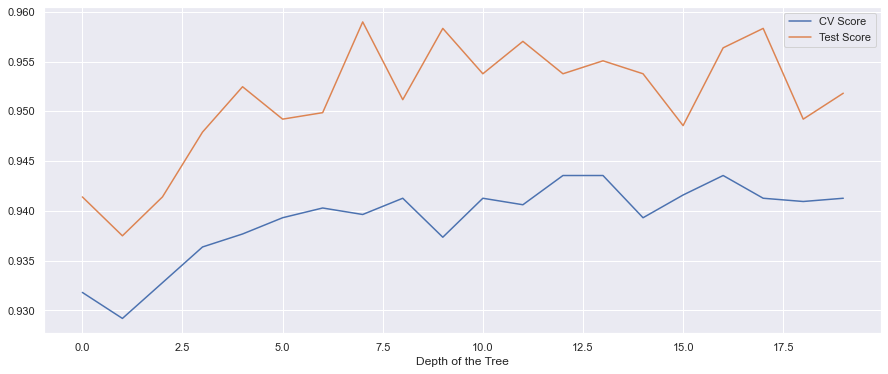

In [205]:
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
plt.plot(cv_scores)
plt.plot(test_scores)
plt.legend(['CV Score','Test Score'])
plt.xlabel('Depth of the Tree')

**Bagging for Spam Data**

In [219]:
# Dataset
df = pd.read_csv('spambase.data', header = None)

# Column names
names = pd.read_csv('spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')

# Rename df columns
df.columns = col_names

# Train - test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'Spam').values, 
                                                    df['Spam'].values, 
                                                    train_size = 3065, 
                                                    random_state = 2) 

In [225]:
## Build model
bagging = Bagging()
bagging.fit(X_train, y_train, B = 1000, max_depth = 20, seed = 123)
y_test_hat = bagging.predict(X_test)

In [226]:
y_test_hat.shape

(1536,)

In [227]:
print(confusion_matrix(y_test,y_test_hat))
print(classification_report(y_test,y_test_hat))

[[883  25]
 [ 70 558]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       908
           1       0.96      0.89      0.92       628

    accuracy                           0.94      1536
   macro avg       0.94      0.93      0.94      1536
weighted avg       0.94      0.94      0.94      1536



In [228]:
accuracy = len(y_test[y_test_hat==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 93.82%


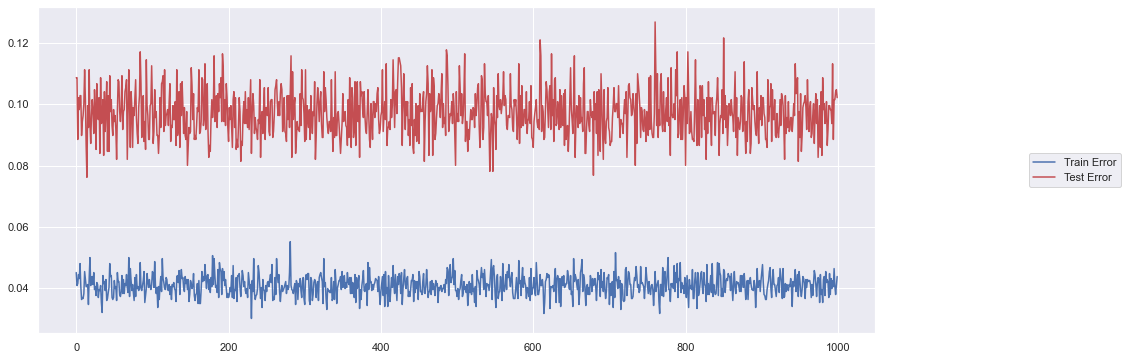

In [229]:
bagging.plot_errors(X_train,y_train,X_test,y_test)

In [230]:
depths = [1,2,5,50]
numbags = range(1,100,4)
letter_train_bag_errorrates=np.empty((len(depths),len(numbags)))
letter_test_bag_errorrates=np.empty((len(depths),len(numbags)))
for i in range(len(depths)):
    depth=depths[i]
    for j in range(len(numbags)):
        bags=numbags[j]
        bagging = Bagging()
        bagging.fit(X_train, y_train, B = bags, max_depth = depth, seed = 123)
        train_y_pred=bagging.predict(X_train)
        test_y_pred = bagging.predict(X_test)
        train_accuracy = len(y_train[train_y_pred==y_train])/len(y_train)
        test_accuracy = len(y_test[test_y_pred==y_test])/len(y_test)
        letter_train_bag_errorrates[i][j]=1-train_accuracy
        letter_test_bag_errorrates[i][j]=1-test_accuracy
        

In [231]:
tex=['Train Depth-']*len(depths)
tex+=(['Test Depth-']*len(depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, depths*2)]

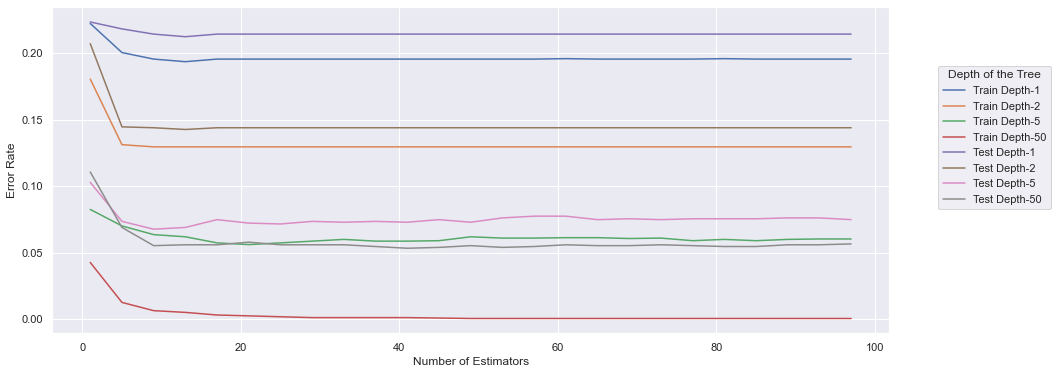

In [232]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":numbags, "acc":letter_train_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":numbags, "acc":letter_test_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg,loc='center right',bbox_to_anchor=(1.2,0.6),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

In [233]:
dc=DecisionTreeClassifier(max_depth=50)
dc.fit(X_train,y_train)
scores=cross_val_score(dc,X_train,y_train,cv=5)
y_pred=dc.predict(X_test)

In [234]:
np.mean(scores)

0.9004893964110929

In [235]:
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 91.47%


Now, let's compare with Bagging output.

In [237]:
bagging = Bagging()
bagging.fit(X_train, y_train, B = 100, max_depth = 50, seed = 123)
y_pred = bagging.predict(X_test)
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 94.34%


There is an improvement of accuracy by 3% compared to the base learner.

Let's plot Bagging vs Boosting test errors as a function of T (bags for bagging, n_estimators for boosting). I would expect boosting to outperform bagging as seen above. But, still we need to remember, Boosting is prone to overfitting.

In [240]:
bagging_depths=[1,50]
boost_depths = [1,2]
n = [1,2,3,4,5,6,7,8,9,10,50,100,200,300,400,500,1000,2000]
test_boost_errorrates=np.empty((len(depths),len(n)))
test_bag_errorrates=np.empty((len(depths),len(n)))
for i in range(len(bagging_depths)):
    bag_depth=bagging_depths[i]
    boost_depth=boost_depths[i]
    
    for j in range(len(n)):
        rep=n[j]
        bagging = Bagging()
        bagging.fit(X_train, y_train, B = rep, max_depth = bag_depth, seed = 123)
        test_y_pred = bagging.predict(X_test)
        test_accuracy = len(y_test[test_y_pred==y_test])/len(y_test)
        test_bag_errorrates[i][j]=1-test_accuracy
        
        y_train2=np.where(y_train==0,-1,1)
        y_test2=np.where(y_test==0,-1,1)    
        ab = AdaBoost(T=rep,max_depth=boost_depth)
        ab.fit(X_train, y_train2)
        test_y_pred = ab.predict(X_test)
        test_accuracy = len(y_test2[test_y_pred==y_test2])/len(y_test2)
        test_boost_errorrates[i][j]=1-test_accuracy

In [241]:
tex=['Bagging Depth-']*len(bagging_depths)
tex1=(['Boosting Depth-']*len(boost_depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, bagging_depths)]
leg1=["{}{}".format(a_, b_) for a_, b_ in zip(tex1, boost_depths)]
leg_final=leg+leg1

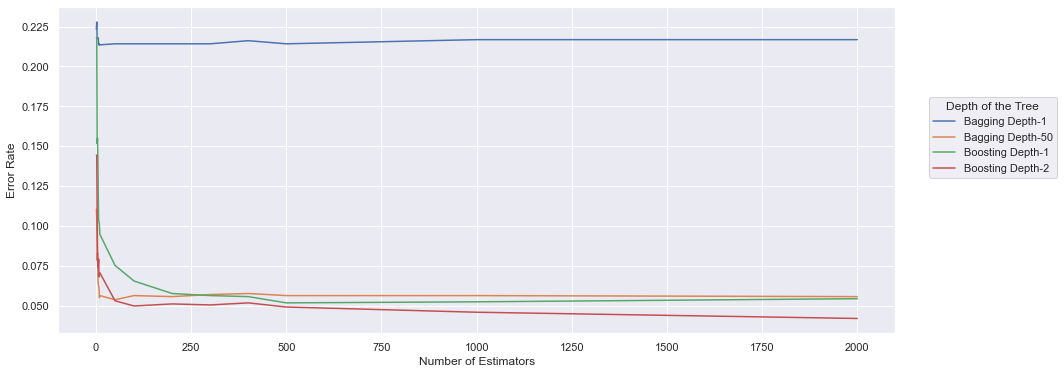

In [243]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(bagging_depths)):
    data_plot = pd.DataFrame({"n_estimators":n, "acc":test_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(bagging_depths)):
    data_plot = pd.DataFrame({"n_estimators":n, "acc":test_boost_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg_final,loc='center right',bbox_to_anchor=(1.2,0.6),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

In [244]:
spam_bag_errors=test_bag_errorrates
spam_boost_errors=test_boost_errorrates

**German Credit Data**

In [245]:
# Dataset
df = pd.read_fwf('german.data-numeric', header = None)

In [246]:
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,1
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,1
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,1
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,2


In [247]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:24].values, 
                                                    df.iloc[:,24].values, 
                                                    random_state = 2)

**Boosting on German Credit Dataset**

In [250]:
y_train=np.where(y_train==1,-1,1)
y_test=np.where(y_test==1,-1,1)

In [259]:
# Fit model
ab = AdaBoost(T=100,max_depth=2)
ab.fit(X_train,y_train)

# Predict on test set
y_pred = ab.predict(X_test)

In [260]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[143  23]
 [ 40  44]]
              precision    recall  f1-score   support

          -1       0.78      0.86      0.82       166
           1       0.66      0.52      0.58        84

    accuracy                           0.75       250
   macro avg       0.72      0.69      0.70       250
weighted avg       0.74      0.75      0.74       250



In [261]:
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 74.80%


In [262]:
test_errors=ab.test_errors(X_test,y_test)

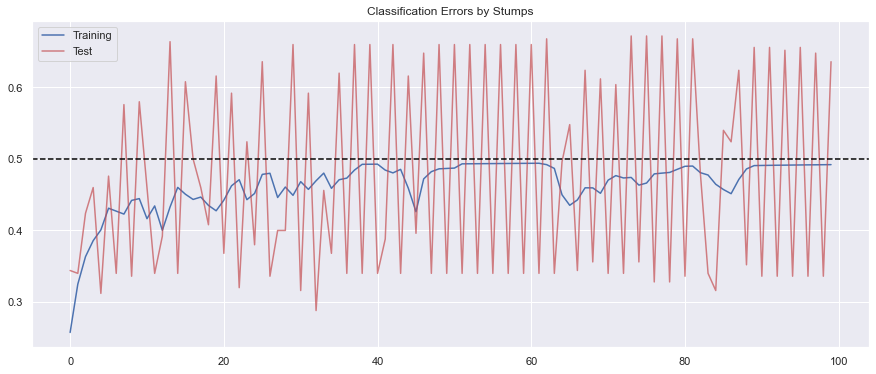

In [263]:
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
plt.plot(ab.training_errors)
plt.plot(ab.prediction_errors,c='r',alpha=0.7)
plt.axhline(0.5,c='black',linestyle='--')
plt.legend(['Training','Test'])
plt.title('Classification Errors by Stumps')
plt.show()

In [264]:
depths = [1,2,5]
n_estimators = [1,2,3,4,5,6,7,8,9,10,50,100,200,300,400,500,1000,2000]
letter_train_errorrates=np.empty((len(depths),len(n_estimators)))
letter_test_errorrates=np.empty((len(depths),len(n_estimators)))
for i in range(len(depths)):
    depth=depths[i]
    for j in range(len(n_estimators)):
        estimators=n_estimators[j]
        #print(depth,estimators),
        ab = AdaBoost(T=estimators,max_depth=depth)
        ab.fit(X_train, y_train)
        y_pred = ab.predict(X_test)
        y_train_pred=ab.predict(X_train)
        train_accuracy= len(y_train[y_train_pred==y_train])/len(y_train)
        test_accuracy = len(y_test[y_pred==y_test])/len(y_test)
        letter_train_errorrates[i][j]=1-train_accuracy
        letter_test_errorrates[i][j]=1-test_accuracy

In [265]:
tex=['Train Depth-']*len(depths)
tex+=(['Test Depth-']*len(depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, depths*2)]

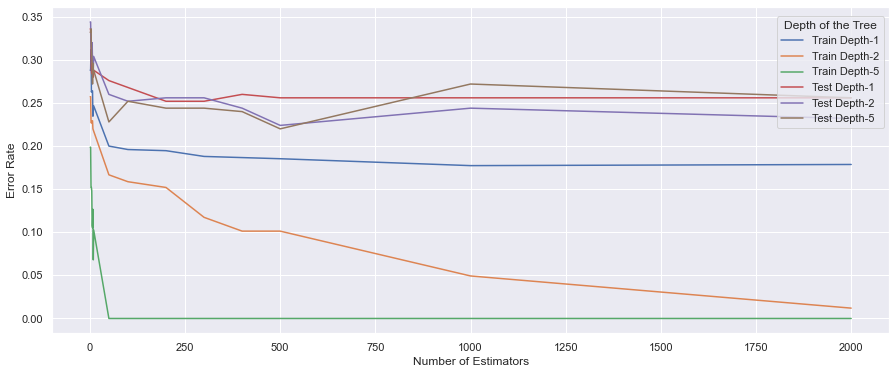

In [266]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":n_estimators, "acc":letter_train_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":n_estimators, "acc":letter_test_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg,loc='center right',bbox_to_anchor=(1,0.8),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

We can see that depth 2 is out performing other depths. Now let's check if the model is overfitting by doing cross-validation for different depths.

In [267]:
cv_scores=np.zeros(20)
test_scores=np.zeros(20)
for i in range(1,21):
    ad2=AdaBoostClassifier(n_estimators=100,base_estimator=DecisionTreeClassifier(max_depth=i))
    ad2.fit(X_train,y_train)
    y_pred = ad2.predict(X_test)
    cv_scores[i-1] =np.mean(cross_val_score(ad2, X_train,y_train, cv=5))
    test_scores[i-1]=len(y_test[y_pred==y_test])/len(y_test)

Text(0.5, 0, 'Depth of the Tree')

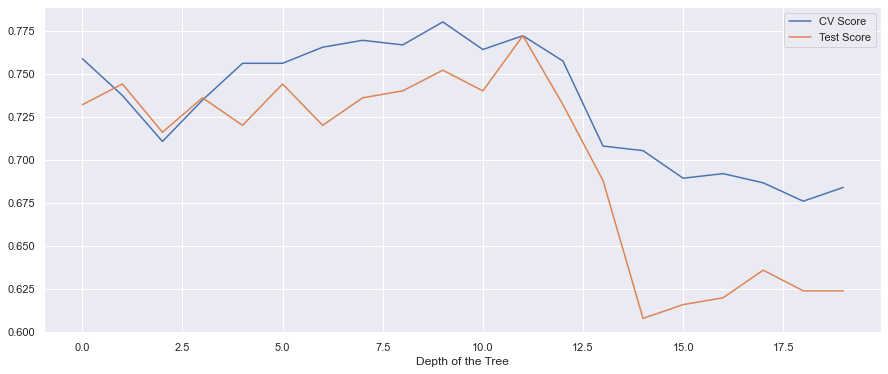

In [268]:
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
plt.plot(cv_scores)
plt.plot(test_scores)
plt.legend(['CV Score','Test Score'])
plt.xlabel('Depth of the Tree')

**Bagging for German Credit Data**

In [269]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:24].values, 
                                                    df.iloc[:,24].values, 
                                                    random_state = 2)

In [270]:
## Build model
bagging = Bagging()
bagging.fit(X_train, y_train, B = 1000, max_depth = 20, seed = 123)
y_test_hat = bagging.predict(X_test)

In [271]:
print(confusion_matrix(y_test,y_test_hat))
print(classification_report(y_test,y_test_hat))

[[148  18]
 [ 39  45]]
              precision    recall  f1-score   support

           1       0.79      0.89      0.84       166
           2       0.71      0.54      0.61        84

    accuracy                           0.77       250
   macro avg       0.75      0.71      0.73       250
weighted avg       0.77      0.77      0.76       250



In [272]:
accuracy = len(y_test[y_test_hat==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 77.20%


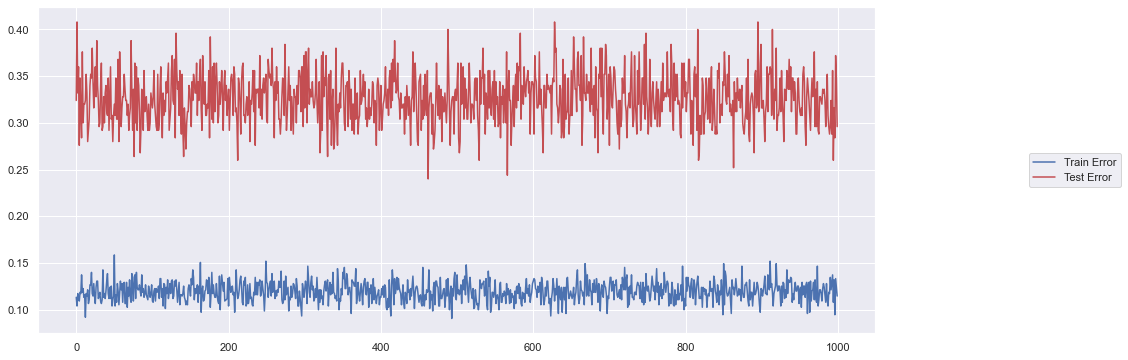

In [273]:
bagging.plot_errors(X_train,y_train,X_test,y_test)

In [274]:
depths = [1,2,5,50]
numbags = range(1,100,4)
german_train_bag_errorrates=np.empty((len(depths),len(numbags)))
german_test_bag_errorrates=np.empty((len(depths),len(numbags)))
for i in range(len(depths)):
    depth=depths[i]
    for j in range(len(numbags)):
        bags=numbags[j]
        bagging = Bagging()
        bagging.fit(X_train, y_train, B = bags, max_depth = depth, seed = 123)
        train_y_pred=bagging.predict(X_train)
        test_y_pred = bagging.predict(X_test)
        train_accuracy = len(y_train[train_y_pred==y_train])/len(y_train)
        test_accuracy = len(y_test[test_y_pred==y_test])/len(y_test)
        german_train_bag_errorrates[i][j]=1-train_accuracy
        german_test_bag_errorrates[i][j]=1-test_accuracy
        

In [275]:
tex=['Train Depth-']*len(depths)
tex+=(['Test Depth-']*len(depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, depths*2)]

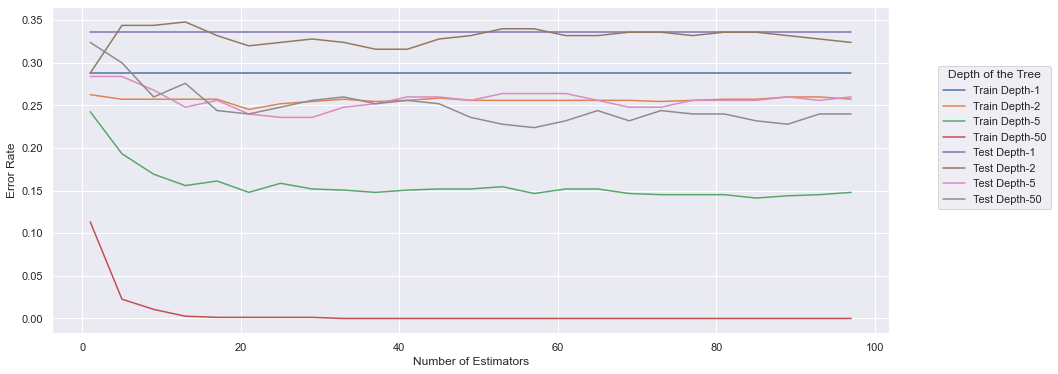

In [281]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":numbags, "acc":german_train_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(depths)):
    data_plot = pd.DataFrame({"n_estimators":numbags, "acc":german_test_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg,loc='center right',bbox_to_anchor=(1.2,0.6),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

In [277]:
dc=DecisionTreeClassifier(max_depth=50)
dc.fit(X_train,y_train)
scores=cross_val_score(dc,X_train,y_train,cv=5)
y_pred=dc.predict(X_test)

In [278]:
np.mean(scores)

0.6813333333333332

In [279]:
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 62.00%


Now, let's compare with Bagging output.

In [282]:
bagging = Bagging()
bagging.fit(X_train, y_train, B = 100, max_depth = 50, seed = 123)
y_pred = bagging.predict(X_test)
accuracy = len(y_test[y_pred==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))

Accuracy : 77.20%


There is an improvement of accuracy by 15% compared to the base learner. This is a huge improvement than the base learner. This clearly, shows how the variance is improved for the test set.

Let's plot Bagging vs Boosting test errors as a function of T (bags for bagging, n_estimators for boosting). I would expect boosting to outperform bagging as seen above. But, still we need to remember, Boosting is prone to overfitting.

In [288]:
bagging_depths=[1,25,50]
boost_depths = [1,2,5]
n = [1,2,3,4,5,6,7,8,9,10,50,100,200,300,400,500,1000,2000]
test_boost_errorrates=np.empty((len(depths),len(n)))
test_bag_errorrates=np.empty((len(depths),len(n)))
for i in range(len(bagging_depths)):
    bag_depth=bagging_depths[i]
    boost_depth=boost_depths[i]
    
    for j in range(len(n)):
        rep=n[j]
        bagging = Bagging()
        bagging.fit(X_train, y_train, B = rep, max_depth = bag_depth, seed = 123)
        test_y_pred = bagging.predict(X_test)
        test_accuracy = len(y_test[test_y_pred==y_test])/len(y_test)
        test_bag_errorrates[i][j]=1-test_accuracy
        
        y_train2=np.where(y_train==1,-1,1)
        y_test2=np.where(y_test==1,-1,1)    
        ab = AdaBoost(T=rep,max_depth=boost_depth)
        ab.fit(X_train, y_train2)
        test_y_pred = ab.predict(X_test)
        test_accuracy = len(y_test2[test_y_pred==y_test2])/len(y_test2)
        test_boost_errorrates[i][j]=1-test_accuracy

In [291]:
german_bag_errors=test_bag_errorrates
german_boost_errors=test_boost_errorrates

In [289]:
tex=['Bagging Depth-']*len(bagging_depths)
tex1=(['Boosting Depth-']*len(boost_depths))
leg=["{}{}".format(a_, b_) for a_, b_ in zip(tex, bagging_depths)]
leg1=["{}{}".format(a_, b_) for a_, b_ in zip(tex1, boost_depths)]
leg_final=leg+leg1

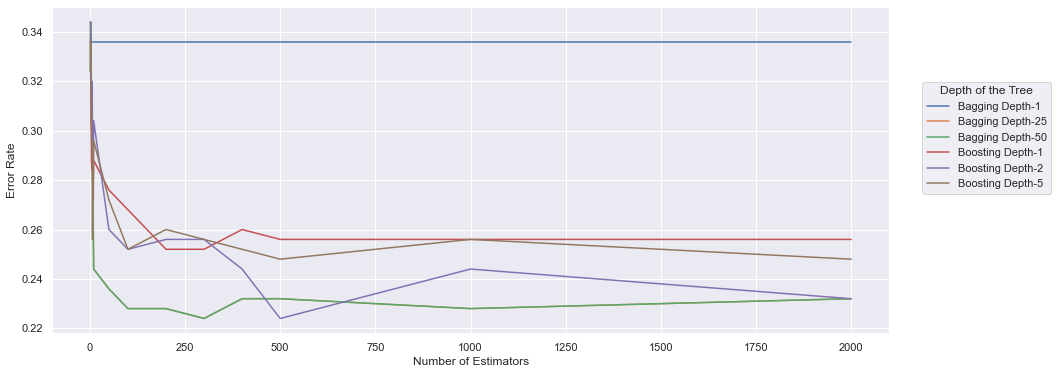

In [290]:
# plot results
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
for i in range(len(bagging_depths)):
    data_plot = pd.DataFrame({"n_estimators":n, "acc":test_bag_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")

for i in range(len(bagging_depths)):
    data_plot = pd.DataFrame({"n_estimators":n, "acc":test_boost_errorrates[i,:]})
    sns.lineplot(data=data_plot,x="n_estimators",y="acc",palette="Set2")
    
plt.legend(leg_final,loc='center right',bbox_to_anchor=(1.2,0.6),title="Depth of the Tree")
plt.xlabel("Number of Estimators",fontsize=12);
plt.ylabel("Error Rate",fontsize=12);
plt.show()

Here bagging with 1000 boostraps and boosting with depth 2 and 500 estimators are almost performing the best.

<h3>Summary of the Results</h3>

**Best Classifier for Letter Dataset:**
<li>Boosting with depth 2 for the weak classifier.</li>
<li> Best Test Accuracy = 99% </li>

**Best Classifier for Spam Dataset:**
<li>Boosting with depth 2 for the weak classifier.</li>
<li>Best Test Accuracy = 98.5%</li>

**Best Classifier for German Dataset:**
<li>Bagging with depth 50 or Boosting with depth 2 and 500 estimators</li>
<li>Best Test Accuracy = 77%</li>

*References:*

<li>https://web.njit.edu/~usman/courses/cs675_fall16/Comparing_Univariate_and_Multivariate_De.pdf</li>
<li>https://gkunapuli.github.io/files/cs6375/11-Bagging.pdf</li>
<li>https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50</li>
<li>https://dafriedman97.github.io/mlbook/content/c6/s2/bagging.html</li>